## Import Libraries

In [39]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [40]:
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm import tqdm

class Node2Vec(nn.Module):
    def __init__(self, graph, dimensions, walk_length, num_walks, p, q, T, learning_rate, window_size):
        super(Node2Vec, self).__init__()
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.T = T  # Length of random walks for similarity
        self.learning_rate = learning_rate
        self.window_size = window_size

        # Check if GPU is available and set device accordingly
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize node embeddings on the selected device
        self.node_embeddings = nn.Embedding(len(graph.nodes()), dimensions).to(self.device)
        nn.init.xavier_uniform_(self.node_embeddings.weight)

    def node2vec_walk(self, start_node):
        walk = [start_node]
        while len(walk) < self.walk_length:
            current_node = walk[-1]
            neighbors = list(self.graph.neighbors(current_node))
            if len(neighbors) > 0:
                next_node = self.node2vec_step(current_node, walk[-2] if len(walk) > 1 else None)
                walk.append(next_node)
            else:
                break
        return walk

    def node2vec_step(self, current_node, previous_node):
        neighbors = list(self.graph.neighbors(current_node))
        if previous_node is None:
            return random.choice(neighbors)

        weights = []
        for neighbor in neighbors:
            if neighbor == previous_node:
                weights.append(1 / self.p)
            elif neighbor in self.graph[previous_node]:
                weights.append(1)
            else:
                weights.append(1 / self.q)

        normalized_weights = [w / sum(weights) for w in weights]
        return random.choices(neighbors, weights=normalized_weights)[0]

    def train(self):
        optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Use tqdm to create a progress bar with the total number of walks
        pbar = tqdm(total=self.num_walks, desc="Total Walks")
        for _ in range(self.num_walks):
            pbar.update(1)  # Update the progress bar by 1 walk
            for node in self.graph.nodes():
                walk = self.node2vec_walk(node)
                self.update_embeddings(walk, optimizer, criterion)
        pbar.close()  # Close the progress bar when done

    def update_embeddings(self, walk, optimizer, criterion):
        for i, node in enumerate(walk):
            for j in range(max(0, i - self.window_size), min(len(walk), i + self.window_size + 1)):
                if i != j:
                    node_i = torch.tensor(walk[i]).to(self.device)
                    node_j = torch.tensor(walk[j]).to(self.device)

                    # Calculate loss and update embeddings based on probability of visit
                    loss = self.node_similarity_loss(node_i, node_j)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

    def node_similarity_loss(self, node_i, node_j):
        emb_i = self.node_embeddings(node_i)
        emb_j = self.node_embeddings(node_j)

        # Probability of visiting node_j on a length-T random walk starting at node_i
        prob_ij = torch.sigmoid(torch.matmul(emb_i, emb_j.t()))

        # small epsilon to avoid division by zero
        epsilon = 1e-8
        prob_ij = torch.max(prob_ij, torch.tensor(epsilon).to(self.device))

        # Negative log likelihood as the loss
        return -torch.log(prob_ij)

    def get_embeddings(self):
        return {node: self.node_embeddings(torch.tensor(node).to(self.device)).cpu().detach().numpy() for node in self.graph.nodes()}


<IPython.core.display.Javascript object>

In [7]:
import torch

<IPython.core.display.Javascript object>

In [8]:
torch.cuda.is_available()

True

<IPython.core.display.Javascript object>

In [9]:
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import importlib

<IPython.core.display.Javascript object>

In [10]:
import graph_reader
from node_2vec import Node2Vec

<IPython.core.display.Javascript object>

In [11]:
# Reload the GraphReader module
importlib.reload(graph_reader)

<module 'graph_reader' from 'D:\\Data\\MSc Data Science\\Uni\\Project Work\\Graph Represt - Prof Chris Brau\\Graphs_learning\\Graph_Represenation\\code\\graph_reader.py'>

<IPython.core.display.Javascript object>

## Read the Dataset and create instances for each dataset

In [12]:
GraphReader = graph_reader.GraphReader

<IPython.core.display.Javascript object>

In [13]:
current_directory = os.path.abspath(os.getcwd())

<IPython.core.display.Javascript object>

In [14]:
# Join the current directory with the 'Data' directory
directory_path = os.path.join(current_directory, "Data")

<IPython.core.display.Javascript object>

In [15]:
# Create an instance of the GraphReader class
graph_reader = GraphReader()

<IPython.core.display.Javascript object>

In [16]:
# Read and store graphs from the directory
graph_data = graph_reader.read_files_in_directory(directory_path)

<IPython.core.display.Javascript object>

In [17]:
# Save graphs in separate variables using their file names
saved_graphs = {}
for file_name, data in graph_data.items():
    graph_name = file_name.replace(".", "_")  # Create a valid variable name
    saved_graphs[graph_name] = data["graph"]

<IPython.core.display.Javascript object>

In [18]:
# Acess the saved graphs using the variable names
for graph_name, graph in saved_graphs.items():
    print(f"Graph name: {graph_name}")
    print("Nodes:", graph.nodes())
    print("Edges:", graph.edges())
    print()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(0, 137), (0, 206), (0, 243), (0, 954), (0, 974), (0, 1552), (0, 1586), (0, 1839), (0, 1903), (0, 2137), (0, 2158), (0, 2367), (0, 3006), (0, 3225), (0, 3361), (0, 3405), (0, 3583), (0, 3644), (1, 805), (1, 823), (1, 824), (1, 992), (1, 1309), (1, 1462), (1, 2083), (1, 2788), (1, 2799), (1, 2802), (1, 3318), (1, 3574), (1, 3788), (2, 428), (2, 3473), (3, 529), (3, 898), (3, 3757), (4, 4), (4, 10), (4, 137), (4, 488), (4, 532), (4, 823), (4, 880), (4, 881), (4, 882), (4, 1042), (4, 1556), (4, 1612), (4, 1613), (4, 1614), (4, 1654), (4, 1669), (4, 1750), (4, 1799), (4, 1824), (4, 2154), (4, 2162), (4, 2329), (4, 2658), (4, 2670), (4, 2796), (4, 2848), (4, 2928), (4, 2985), (4, 3589), (4, 3680), (4, 3738), (4, 3818), (5, 5), (5, 288), (5, 824), (5, 973), (5, 1834), (5, 2280), (5, 2483), (5, 3630), (6, 488), (7, 137), (7, 1248), (7, 3585), (7, 3749), (8, 3630), (9, 237), (9, 1588), (9, 1874), (9, 1929), (9, 2547), (9, 3158), (9, 3339), (10, 10), (10, 14), (10, 47), (10, 186), (10, 232), (

<IPython.core.display.Javascript object>

In [21]:
graph_name, graph = list( saved_graphs.items():

SyntaxError: invalid syntax (789810007.py, line 1)

ERROR:root:Cannot parse: 1:46: graph_name, graph = list( saved_graphs.items():
Traceback (most recent call last):
  File "C:\Users\psraj\miniconda3\envs\torch\lib\site-packages\lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "C:\Users\psraj\miniconda3\envs\torch\lib\site-packages\lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "C:\Users\psraj\miniconda3\envs\torch\lib\site-packages\black\__init__.py", line 1085, in format_str
    dst_contents = _format_str_once(src_contents, mode=mode)
  File "C:\Users\psraj\miniconda3\envs\torch\lib\site-packages\black\__init__.py", line 1095, in _format_str_once
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "C:\Users\psraj\miniconda3\envs\torch\lib\site-packages\black\parsing.py", line 100, in lib2to3_parse
    raise exc from None
black.parsing.InvalidInput: Cannot parse: 1:46: graph_name, graph = list( saved_graphs.items

In [22]:
first_graph_name, G = list(saved_graphs.items())[2]

<IPython.core.display.Javascript object>

In [23]:
first_graph_name

'ppi_mat'

<IPython.core.display.Javascript object>

In [24]:
help(G)

Help on Graph in module networkx.classes.graph object:

class Graph(builtins.object)
 |  Graph(incoming_graph_data=None, **attr)
 |  
 |  Base class for undirected graphs.
 |  
 |  A Graph stores nodes and edges with optional data, or attributes.
 |  
 |  Graphs hold undirected edges.  Self loops are allowed but multiple
 |  (parallel) edges are not.
 |  
 |  Nodes can be arbitrary (hashable) Python objects with optional
 |  key/value attributes, except that `None` is not allowed as a node.
 |  
 |  Edges are represented as links between nodes with optional
 |  key/value attributes.
 |  
 |  Parameters
 |  ----------
 |  incoming_graph_data : input graph (optional, default: None)
 |      Data to initialize graph. If None (default) an empty
 |      graph is created.  The data can be any format that is supported
 |      by the to_networkx_graph() function, currently including edge list,
 |      dict of dicts, dict of lists, NetworkX graph, 2D NumPy array, SciPy
 |      sparse matrix, or 

<IPython.core.display.Javascript object>

In [106]:
data = scipy.io.loadmat("POS.mat")

In [107]:
print(f"Graph name: {G}")
print("Nodes:", G.nodes())
print("Edges:", G.edges())

Graph name: Graph with 3890 nodes and 38739 edges
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

In [25]:
data

{'nodes': NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 

<IPython.core.display.Javascript object>

In [26]:
# Find the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 3890
Number of edges: 38739


<IPython.core.display.Javascript object>

In [27]:
# Set random seed for reproducibility
import numpy as np

seed_value = 42
np.random.seed(seed_value)

<IPython.core.display.Javascript object>

In [28]:
# Create a graph
G = nx.karate_club_graph()


<IPython.core.display.Javascript object>

In [29]:
# # List of dimensions and walk lengths to iterate over
# dimension_list = [32, 64, 128]
# walk_length_list = [10, 20, 40]

# # Create a figure with subplots
# fig, axes = plt.subplots(nrows=len(dimension_list) * len(walk_length_list), ncols=2, figsize=(25, 25))

# # Iterate over different dimensions
# for d_idx, dimensions in enumerate(dimension_list):
#     for w_idx, walk_length in enumerate(walk_length_list):
#         # Set random seed for Node2Vec and NumPy within each iteration
#         np.random.seed(seed_value)

#         # Create the Node2Vec model instance
#         node2vec = Node2Vec(G, p=0.4, q=0.5, dimensions=dimensions, num_walks=10, walk_length=walk_length, window_size=10, num_epochs=100, workers=4)

#         # Train the embedding model using your custom class's train_embedding() method
#         model = node2vec.train_embedding()

#         # Embed all nodes
#         node_embeddings = {node: model.wv[node] for node in G.nodes()}

#         # Visualize the original graph
#         pos = nx.spring_layout(G, seed=seed_value)
#         ax = axes[d_idx * len(walk_length_list) + w_idx, 0]
#         nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, ax=ax)
#         ax.set_title(f"Original Graph (Dimensions={dimensions}, Walk Length={walk_length})")

#         # Plot the embeddings with node numbers
#         ax = axes[d_idx * len(walk_length_list) + w_idx, 1]
#         for node, embedding in node_embeddings.items():
#             ax.scatter(embedding[0], embedding[1], s=100)
#             ax.text(embedding[0], embedding[1], str(node), fontsize=10, ha='center', va='center')
#         ax.set_title(f"Node2Vec Embeddings (Dimensions={dimensions}, Walk Length={walk_length})")

# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>

In [30]:
# node2vec = Node2Vec(G, p=0.4, q=0.5, dimensions=64, num_walks=4, walk_length=5, window_size=10, num_epochs=100, workers=4)
node2vec = Node2Vec(
    G,
    p=best_p,
    q=best_q,
    dimensions=2,
    num_walks=20,
    walk_length=10,
    window_size=10,
    num_epochs=100,
    workers=4,
)

NameError: name 'best_p' is not defined

<IPython.core.display.Javascript object>

In [62]:
# Embed all nodes
node_embeddings = node2vec.embed_all_nodes()

In [63]:
len(node_embeddings)

34

In [64]:
print("Number of nodes in the graph:", len(G.nodes()))
print("Nodes in the graph:", G.nodes())

Number of nodes in the graph: 34
Nodes in the graph: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [65]:
# # Embed all nodes
# node_embeddings = {}
# for node in first_graph.nodes():
#     if node in node2vec.model.wv:
#         node_embeddings[node] = node2vec.model.wv[node]
#     else:
#         print("Embedding not found for node:", node)

In [66]:
# Let's say you want to find similar nodes to a specific node 'target_node'
target_node = 2
target_embedding = node_embeddings[target_node]

In [67]:
target_embedding

array([-0.36831808,  0.9237762 ], dtype=float32)

In [68]:
# Calculate the similarity between the target_embedding and other node embeddings
similar_nodes = []
for node, embedding in node_embeddings.items():
    similarity = np.dot(target_embedding, embedding) / (np.linalg.norm(target_embedding) * np.linalg.norm(embedding))
    similar_nodes.append((node, similarity))


In [69]:
# Sort the list of similar nodes based on similarity
similar_nodes.sort(key=lambda x: x[1], reverse=True)
# print("Similar nodes to", target_node, ":", similar_nodes[:5])

In [70]:
similar_nodes

[(2, 1.0),
 (8, 0.9997903),
 (30, 0.98265034),
 (13, 0.9679369),
 (28, 0.9579665),
 (9, 0.9455258),
 (19, 0.926704),
 (3, 0.90747243),
 (1, 0.89663833),
 (7, 0.8834633),
 (20, 0.8809724),
 (33, 0.8722086),
 (15, 0.85383785),
 (14, 0.8500457),
 (32, 0.8392749),
 (18, 0.8349073),
 (22, 0.832857),
 (31, 0.8297113),
 (27, 0.8207015),
 (21, 0.8197131),
 (12, 0.81900597),
 (29, 0.8035508),
 (26, 0.8030487),
 (17, 0.7667248),
 (23, 0.76011413),
 (0, 0.75239235),
 (24, 0.73816955),
 (25, 0.7345497),
 (11, 0.68605506),
 (10, 0.6323973),
 (4, 0.63052064),
 (5, 0.6161995),
 (6, 0.6133075),
 (16, 0.60619146)]

In [60]:
similar_nodes

[(2, 1.0),
 (28, 0.9999807),
 (12, 0.9999188),
 (7, 0.99991006),
 (13, 0.99986935),
 (23, 0.9990215),
 (3, 0.99869555),
 (1, 0.99803793),
 (27, 0.99132454),
 (31, 0.9911758),
 (17, 0.98511267),
 (24, 0.9761877),
 (25, 0.972304),
 (19, 0.9719891),
 (21, 0.92581517),
 (9, 0.9114821),
 (29, 0.9107257),
 (26, 0.8916625),
 (33, 0.8601431),
 (8, 0.84513044),
 (30, 0.82209533),
 (18, 0.81345546),
 (22, 0.78007954),
 (32, 0.7751047),
 (0, 0.7372253),
 (14, 0.73341393),
 (20, 0.69215316),
 (15, 0.66061413),
 (11, 0.5923577),
 (4, 0.24201295),
 (10, 0.23336358),
 (5, 0.22075327),
 (16, 0.21909095),
 (6, 0.21214564)]

In [49]:
# Calculate geodesic distances from target node to similar nodes
geodesic_distances = {}
for node, _ in similar_nodes:
    geodesic_distance = nx.shortest_path_length(G, source=target_node, target=node)
    geodesic_distances[node] = geodesic_distance


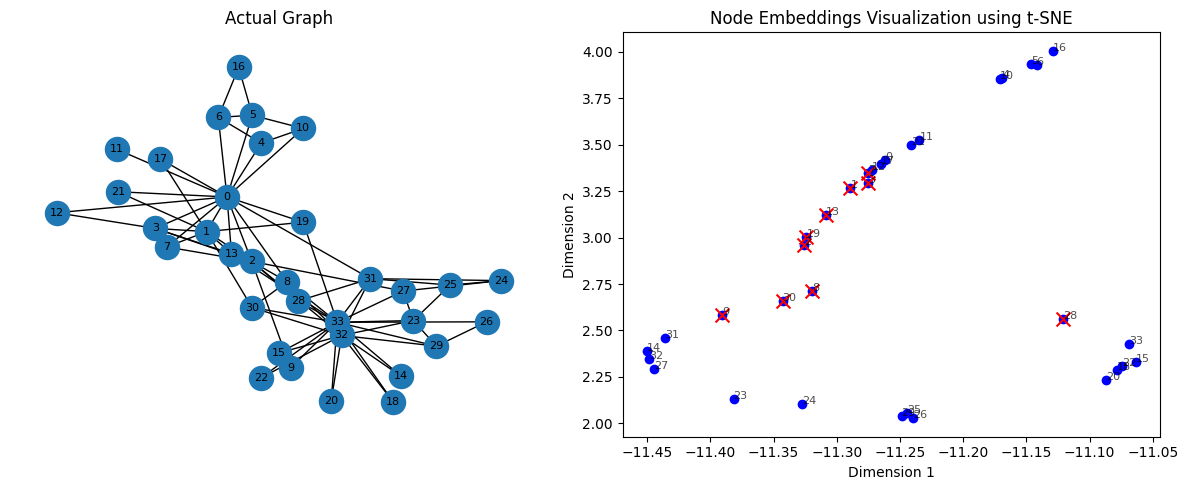

In [50]:
# Set a thrshold for geodesic distance to influence highlighting
threshold = 10  

# Create a new figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visualize actual graph with fixed layout
pos = nx.spring_layout(G, seed=seed_value)  # Layout for the actual graph with fixed seed
nx.draw(G, pos, with_labels=True, font_size=8, ax=axes[0])
axes[0].set_title("Actual Graph")

# Visualize embeddings using t-SNE
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
tsne = TSNE(n_components=2, random_state=seed_value)
embedded_nodes = tsne.fit_transform(embedding_matrix)

# Create a scatter plot to visualize embedded nodes with node labels
scatter = axes[1].scatter(embedded_nodes[:, 0], embedded_nodes[:, 1], c='b', marker='o')
for i, node in enumerate(G.nodes()):
    axes[1].annotate(node, (embedded_nodes[i, 0], embedded_nodes[i, 1]), fontsize=8, alpha=0.7)
    
# Highlight nodes with higher similarity and shorter geodesic distances
for node, _ in similar_nodes[:10]:
    idx = list(G.nodes()).index(node)
    geodesic_distance = geodesic_distances[node]
    
    # Adjust color and marker size based on geodesic distance
    color = 'r' if geodesic_distance < threshold else 'b'
    marker_size = 100 if geodesic_distance < threshold else 50
    
    axes[1].scatter(embedded_nodes[idx, 0], embedded_nodes[idx, 1], c=color, marker='x', s=marker_size)

axes[1].set_title("Node Embeddings Visualization using t-SNE")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.tight_layout()
plt.show()

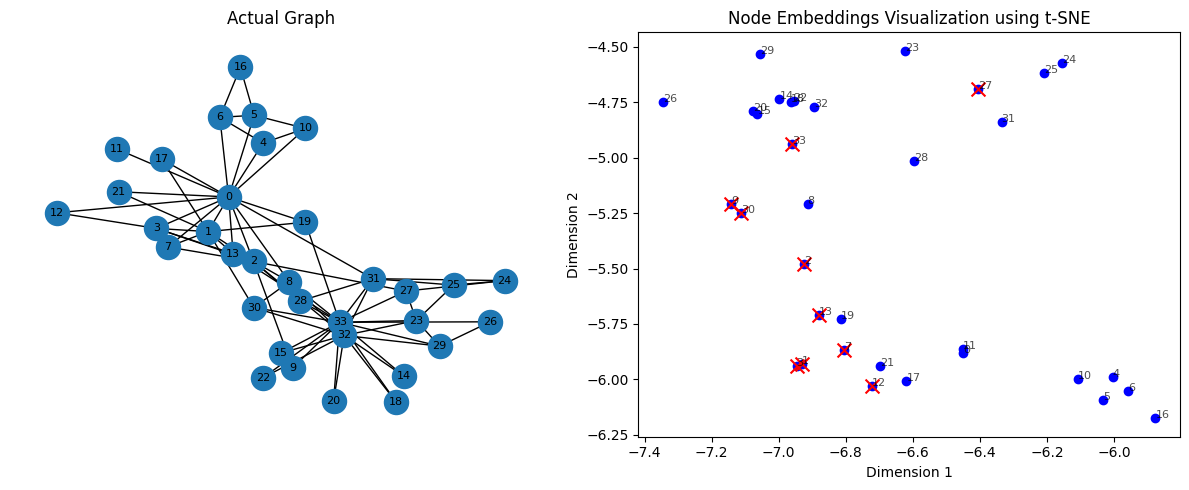

In [33]:
# Set a threshold for geodesic distance to influence highlighting
threshold = 10

# Create a new figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visualize actual graph with fixed layout
seed_value = 42  # Set your desired seed value for reproducibility
pos = nx.spring_layout(G, seed=seed_value)  # Layout for the actual graph with fixed seed
nx.draw(G, pos, with_labels=True, font_size=8, ax=axes[0])
axes[0].set_title("Actual Graph")

# Visualize embeddings using t-SNE
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
tsne = TSNE(n_components=2, random_state=seed_value)
embedded_nodes = tsne.fit_transform(embedding_matrix)

# Create a scatter plot to visualize embedded nodes with node labels
scatter = axes[1].scatter(embedded_nodes[:, 0], embedded_nodes[:, 1], c='b', marker='o')
for i, node in enumerate(G.nodes()):
    axes[1].annotate(node, (embedded_nodes[i, 0], embedded_nodes[i, 1]), fontsize=8, alpha=0.7)

# Highlight nodes with higher similarity and shorter geodesic distances
for node, _ in similar_nodes[:10]:
    idx = list(G.nodes()).index(node)
    geodesic_distance = geodesic_distances[node]
    
    # Adjust color and marker size based on geodesic distance
    color = 'r' if geodesic_distance < threshold else 'b'
    marker_size = 100 if geodesic_distance < threshold else 50
    
    axes[1].scatter(embedded_nodes[idx, 0], embedded_nodes[idx, 1], c=color, marker='x', s=marker_size)

axes[1].set_title("Node Embeddings Visualization using t-SNE")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.tight_layout()
plt.show()

In [ ]:
# Create a new figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Visualize actual graph with fixed layout
pos = nx.spring_layout(G, seed=seed_value)  # Layout for the actual graph with fixed seed
nx.draw(G, pos, with_labels=True, font_size=8, ax=axes[0])
axes[0].set_title("Actual Graph")

# Visualize embeddings using t-SNE
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
tsne = TSNE(n_components=2, random_state=seed_value)
embedded_nodes = tsne.fit_transform(embedding_matrix)

# Create a scatter plot to visualize embedded nodes with node labels
axes[1].scatter(embedded_nodes[:, 0], embedded_nodes[:, 1], c='b', marker='o')
for i, node in enumerate(G.nodes()):
    axes[1].annotate(node, (embedded_nodes[i, 0], embedded_nodes[i, 1]), fontsize=8, alpha=0.7)
    
# Highlight nodes with higher similarity and closer geodesic distances
for node, _ in similar_nodes[:5]:
    idx = list(G.nodes()).index(node)
    axes[1].scatter(embedded_nodes[idx, 0], embedded_nodes[idx, 1], c='r', marker='x', s=100)

axes[1].set_title("Node Embeddings Visualization using t-SNE")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

plt.tight_layout()
plt.show()

In [34]:
# Calculate centrality measures for the original graph
original_degree_centrality = nx.degree_centrality(G)
original_betweenness_centrality = nx.betweenness_centrality(G)

# Calculate centrality measures for the embedding-based graph
embedding_degree_centrality = {}
embedding_betweenness_centrality = {}

for node in G.nodes():
    if node in node_embeddings:
        embedding_degree_centrality[node] = np.linalg.norm(node_embeddings[node])  
        embedding_betweenness_centrality[node] = np.sum(node_embeddings[node])     

# Compare centrality measures
for node in G.nodes():
    if node in node_embeddings:
        original_degree = original_degree_centrality[node]
        embedding_degree = embedding_degree_centrality[node]
        
        original_betweenness = original_betweenness_centrality[node]
        embedding_betweenness = embedding_betweenness_centrality[node]
        
        print(f"Node: {node}")
        print(f"Original Degree Centrality: {original_degree:.4f}, Embedding Degree Centrality: {embedding_degree:.4f}")
        print(f"Original Betweenness Centrality: {original_betweenness:.4f}, Embedding Betweenness Centrality: {embedding_betweenness:.4f}")
        print()

Node: 0
Original Degree Centrality: 0.4848, Embedding Degree Centrality: 1.2992
Original Betweenness Centrality: 0.4376, Embedding Betweenness Centrality: -0.0275

Node: 1
Original Degree Centrality: 0.2727, Embedding Degree Centrality: 1.4476
Original Betweenness Centrality: 0.0539, Embedding Betweenness Centrality: 0.5825

Node: 2
Original Degree Centrality: 0.3030, Embedding Degree Centrality: 1.2166
Original Betweenness Centrality: 0.1437, Embedding Betweenness Centrality: 0.8573

Node: 3
Original Degree Centrality: 0.1818, Embedding Degree Centrality: 1.5158
Original Betweenness Centrality: 0.0119, Embedding Betweenness Centrality: -0.8871

Node: 4
Original Degree Centrality: 0.0909, Embedding Degree Centrality: 1.7907
Original Betweenness Centrality: 0.0006, Embedding Betweenness Centrality: 0.6429

Node: 5
Original Degree Centrality: 0.1212, Embedding Degree Centrality: 1.8455
Original Betweenness Centrality: 0.0300, Embedding Betweenness Centrality: -0.7767

Node: 6
Original De

In [35]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [38]:
# Calculate pairwise Euclidean distances between node embeddings
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
embedding_distances = pdist(embedding_matrix, metric='euclidean')
embedding_distance_matrix = squareform(embedding_distances)

# Create a dictionary to map nodes to their indices in the graph
node_to_index = {node: index for index, node in enumerate(G.nodes())}

# Compare shortest path distances and embedding distances
for node1 in G.nodes():
    for node2 in G.nodes():
        original_distance = nx.shortest_path_length(G, source=node1, target=node2)
        embedding_distance = embedding_distance_matrix[node_to_index[node1]][node_to_index[node2]]
        
        print(f"Nodes: {node1}, {node2}")
        print(f"Original Shortest Path Distance: {original_distance}")
        print(f"Embedding Distance: {embedding_distance:.4f}")
        print()

Nodes: 0, 0
Original Shortest Path Distance: 0
Embedding Distance: 0.0000

Nodes: 0, 1
Original Shortest Path Distance: 1
Embedding Distance: 1.1607

Nodes: 0, 2
Original Shortest Path Distance: 1
Embedding Distance: 1.3431

Nodes: 0, 3
Original Shortest Path Distance: 1
Embedding Distance: 1.2029

Nodes: 0, 4
Original Shortest Path Distance: 1
Embedding Distance: 1.1951

Nodes: 0, 5
Original Shortest Path Distance: 1
Embedding Distance: 1.2913

Nodes: 0, 6
Original Shortest Path Distance: 1
Embedding Distance: 1.3165

Nodes: 0, 7
Original Shortest Path Distance: 1
Embedding Distance: 1.0390

Nodes: 0, 8
Original Shortest Path Distance: 1
Embedding Distance: 1.4318

Nodes: 0, 9
Original Shortest Path Distance: 2
Embedding Distance: 1.7608

Nodes: 0, 10
Original Shortest Path Distance: 1
Embedding Distance: 1.0955

Nodes: 0, 11
Original Shortest Path Distance: 1
Embedding Distance: 1.2947

Nodes: 0, 12
Original Shortest Path Distance: 1
Embedding Distance: 1.2042

Nodes: 0, 13
Original 

In [ ]:
# Visualize embeddings using t-SNE
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
tsne = TSNE(n_components=2, random_state=seed_value)
embedded_nodes = tsne.fit_transform(embedding_matrix)

In [ ]:
embedded_nodes

In [ ]:
# Create a scatter plot to visualize embedded nodes with node labels
plt.figure(figsize=(20, 18))
plt.scatter(embedded_nodes[:, 0], embedded_nodes[:, 1], c='b', marker='o')
for i, node in enumerate(G.nodes()):
    plt.annotate(node, (embedded_nodes[i, 0], embedded_nodes[i, 1]), fontsize=8, alpha=0.7)
plt.title("Node Embeddings Visualization using t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
# Calculate cosine similarity matrix
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
similarity_matrix = cosine_similarity(embedding_matrix)

In [ ]:
similarity_matrix.shape

In [ ]:
# Set a threshold to predict edges
threshold = 0.7

# Reconstructed graph
reconstructed_graph = nx.Graph()

In [ ]:
reconstructed_graph

In [ ]:
# Iterate through nodes and similarity matrix to predict edges
for i, node_i in enumerate(G.nodes()):
    for j, node_j in enumerate(G.nodes()):
        if i != j and similarity_matrix[i, j] > threshold:
            reconstructed_graph.add_edge(node_i, node_j)

In [ ]:
# Calculate Jaccard similarity for original and reconstructed graph
original_edges = set(G.edges())
reconstructed_edges = set(reconstructed_graph.edges())

In [ ]:
jaccard_similarity = len(original_edges.intersection(reconstructed_edges)) / len(original_edges.union(reconstructed_edges))
print("Jaccard Similarity:", jaccard_similarity)

In [ ]:
# Plot the original and reconstructed graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Graph Visualization
pos_original = nx.spring_layout(G, seed=seed_value)
nx.draw(G, pos=pos_original, with_labels=True, font_size=8, ax=axes[0])
axes[0].set_title("Original Graph")

# Reconstructed Graph Visualization
pos_reconstructed = nx.spring_layout(reconstructed_graph, seed=seed_value)
nx.draw(reconstructed_graph, pos=pos_reconstructed, with_labels=True, font_size=8, ax=axes[1])
axes[1].set_title("Reconstructed Graph")

plt.tight_layout()
plt.show()

In [ ]:
# Plot the original and reconstructed graphs
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Graph Visualization
pos_original = nx.spring_layout(G, seed=seed_value)
nx.draw(G, pos=pos_original, with_labels=True, font_size=8, ax=axes[0])
axes[0].set_title("Original Graph")

# Reconstructed Graph Visualization
pos_reconstructed = nx.spring_layout(reconstructed_graph, seed=seed_value)
nx.draw(reconstructed_graph, pos=pos_reconstructed, with_labels=True, font_size=8, ax=axes[1])
nx.draw_networkx_edges(reconstructed_graph, pos=pos_reconstructed, ax=axes[1])
axes[1].set_title("Reconstructed Graph")

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Common Neighbors, Jaccard's Coefficient, Adamic-Adar Score, and Preferential Attachment
common_neighbors = nx.cn_soundarajan_hopcroft(G)
jaccard_coefficient = nx.jaccard_coefficient(G)
adamic_adar_score = nx.adamic_adar_index(G)
preferential_attachment = nx.preferential_attachment(G)

In [ ]:
# Calculate Common Neighbors, Jaccard's Coefficient, Adamic-Adar Score, and Preferential Attachment
for u, v in G.edges():
    common_neighbors = len(list(nx.common_neighbors(G, u, v)))
    jaccard_coefficient = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
    adamic_adar_score = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
    preferential_attachment = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
    
    print(f"Nodes {u} and {v}:")
    print(f"Common Neighbors: {common_neighbors}")
    print(f"Jaccard's Coefficient: {jaccard_coefficient}")
    print(f"Adamic-Adar Score: {adamic_adar_score}")
    print(f"Preferential Attachment: {preferential_attachment}")
    print()
    

In [15]:
def evaluate_embeddings(embeddings, G):
    # Calculate cosine similarity matrix
    embedding_matrix = np.array([embeddings[node] for node in G.nodes()])
    similarity_matrix = cosine_similarity(embedding_matrix)
    
    # Compute the average cosine similarity of neighbors for each node
    avg_neighbor_similarity = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 0:
            avg_similarity = np.mean(similarity_matrix[node][neighbors])
            avg_neighbor_similarity.append(avg_similarity)
    
    # Calculate the mean of average neighbor similarities
    mean_avg_neighbor_similarity = np.mean(avg_neighbor_similarity)
    
    return mean_avg_neighbor_similarity

In [18]:
# Hyperparameter tuning code
p_values = np.arange(0.1, 2.1, 0.1)
q_values = np.arange(0.1, 2.1, 0.1)

best_score = 0.0
best_p = None
best_q = None

for p in p_values:
    for q in q_values:
        node2vec = Node2Vec(G, p=p, q=q, dimensions=64, num_walks=20, walk_length=20, window_size=10, num_epochs=100, workers=4)
        node_embeddings = node2vec.embed_all_nodes()
        
        score = evaluate_embeddings(node_embeddings, G)
        
        if score > best_score:
            best_score = score
            best_p = p
            best_q = q

print("Best p:", best_p)
print("Best q:", best_q)

Best p: 0.8
Best q: 1.6


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [72]:
# Split edges into train and test sets
edges = list(G.edges())
edges_train, edges_test = train_test_split(edges, test_size=0.2, random_state=42)


In [73]:
edges_train

[(2, 32),
 (23, 27),
 (0, 11),
 (0, 6),
 (4, 6),
 (5, 16),
 (26, 33),
 (20, 32),
 (6, 16),
 (1, 2),
 (8, 32),
 (14, 33),
 (18, 32),
 (0, 8),
 (2, 13),
 (30, 33),
 (13, 33),
 (28, 31),
 (1, 13),
 (25, 31),
 (2, 7),
 (22, 32),
 (0, 19),
 (22, 33),
 (0, 4),
 (1, 3),
 (5, 10),
 (0, 10),
 (24, 25),
 (0, 7),
 (4, 10),
 (31, 32),
 (24, 31),
 (14, 32),
 (31, 33),
 (0, 31),
 (2, 9),
 (8, 30),
 (2, 8),
 (15, 32),
 (2, 3),
 (8, 33),
 (28, 33),
 (23, 25),
 (0, 13),
 (3, 7),
 (30, 32),
 (23, 29),
 (24, 27),
 (27, 33),
 (5, 6),
 (2, 27),
 (0, 2),
 (19, 33),
 (1, 19),
 (0, 3),
 (1, 30),
 (1, 17),
 (23, 32),
 (29, 32),
 (0, 21),
 (18, 33)]

In [81]:
# Create positive and negative samples
positive_samples = edges_train
negative_samples = []

# Generate negative samples by randomly shuffling nodes
for _ in range(len(positive_samples)):
    u, v = np.random.choice(list(G.nodes()), size=2, replace=False)
    while G.has_edge(u, v):
        u, v = np.random.choice(list(G.nodes()), size=2, replace=False)
    negative_samples.append((u, v))

# Combine positive and negative samples
samples = positive_samples + negative_samples
labels = [1] * len(positive_samples) + [0] * len(negative_samples)

TypeError: unsupported operand type(s) for //: 'list' and 'int'

In [79]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [75]:
# Convert node pairs to embeddings for train set
train_embeddings = np.array([node_embeddings[u] + node_embeddings[v] for u, v in samples])


In [76]:

# Train a logistic regression classifier on the edge embeddings
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_embeddings, labels)

LogisticRegression(max_iter=1000)

In [77]:
# Predict edges on the test set
test_embeddings = np.array([node_embeddings[u] + node_embeddings[v] for u, v in edges_test])
predictions = classifier.predict(test_embeddings)

In [78]:
# Calculate accuracy
accuracy = accuracy_score([1 if G.has_edge(u, v) else 0 for u, v in edges_test], predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9375


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert node embeddings to array
embedding_array = np.array(list(node_embeddings.values()))

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embedding_array)

# Visualize t-SNE embeddings
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])
plt.title("t-SNE Visualization of Node Embeddings")
plt.show()


In [ ]:
# Get the set of true edges and predicted edges
true_edges = set(G.edges())
predicted_edges = set(reconstructed_graph.edges())

# Calculate the intersection and union of edges for Jaccard similarity
intersection = len(true_edges.intersection(predicted_edges))
union = len(true_edges.union(predicted_edges))

# Calculate Edge Jaccard Similarity
edge_jaccard_similarity = intersection / union

print("Edge Jaccard Similarity for Graph Reconstruction:", edge_jaccard_similarity)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score



# Use KMeans clustering to group nodes
num_clusters = 2  # You can adjust the number of clusters based on your problem
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(list(node_embeddings.values()))

# Assign cluster labels as pseudo-labels
pseudo_labels = {node_id: cluster for node_id, cluster in zip(list(node_embeddings.keys()), cluster_assignments)}

# Split data into train and test sets
nodes_train, nodes_test = train_test_split(list(pseudo_labels.keys()), test_size=0.2, random_state=42)

# Convert node IDs to embeddings for train and test sets
train_embeddings = np.array([node_embeddings[node_id] for node_id in nodes_train])
test_embeddings = np.array([node_embeddings[node_id] for node_id in nodes_test])

# Train a classifier on the pseudo-labels
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_embeddings, cluster_assignments[nodes_train])

# Predict pseudo-labels on the test set
predicted_pseudo_labels = classifier.predict(test_embeddings)

# Calculate accuracy based on pseudo-labels
accuracy = accuracy_score(cluster_assignments[nodes_test], predicted_pseudo_labels)
print("Unsupervised Node Classification Accuracy:", accuracy)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrix between embeddings
embedding_matrix = np.array([node_embeddings[node] for node in G.nodes()])
similarity_matrix = cosine_similarity(embedding_matrix)
# similarity_matrix = cosine_similarity(node_embeddings)

# Set a similarity threshold to predict edges
threshold = 0.3
predicted_edges = [(i, j) for i in range(len(G.nodes())) for j in range(i+1, len(G.nodes())) if similarity_matrix[i, j] > threshold]

# Create a new graph using predicted edges
reconstructed_graph = nx.Graph()
reconstructed_graph.add_edges_from(predicted_edges)

# Assuming you've used the above code to create 'reconstructed_graph', now use it for the Overlap Coefficient calculation:

# Get the set of true edges and predicted edges
true_edges = set(G.edges())
predicted_edges = set(reconstructed_graph.edges())

# Calculate the number of common edges
common_edges = len(true_edges.intersection(predicted_edges))

# Calculate the minimum number of edges in either of the graphs
min_edges = min(len(true_edges), len(predicted_edges))

# Calculate the Overlap Coefficient
overlap_coefficient = common_edges / min_edges

print("Overlap Coefficient for Graph Reconstruction:", overlap_coefficient)


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import jaccard_score

# Calculate Euclidean distance matrix between embeddings
euclidean_distance_matrix = euclidean_distances(embedding_matrix)

# Calculate Jaccard similarity matrix between embeddings
jaccard_similarity_matrix = np.array([[len(set(embedding_matrix[i]) & set(embedding_matrix[j])) /
                                      len(set(embedding_matrix[i]) | set(embedding_matrix[j]))
                                      for j in range(len(embedding_matrix))] for i in range(len(embedding_matrix))])

# Set a threshold for Euclidean distance or Jaccard similarity to predict edges
euclidean_threshold = 2.0
jaccard_threshold = 0.2

# Predict edges based on Euclidean distance
euclidean_predicted_edges = [(i, j) for i in range(len(G.nodes())) for j in range(i + 1, len(G.nodes()))
                             if euclidean_distance_matrix[i, j] < euclidean_threshold]

# Predict edges based on Jaccard similarity
jaccard_predicted_edges = [(i, j) for i in range(len(G.nodes())) for j in range(i + 1, len(G.nodes()))
                           if jaccard_similarity_matrix[i, j] > jaccard_threshold]

# Create reconstructed graphs using predicted edges
reconstructed_graph_euclidean = nx.Graph()
reconstructed_graph_jaccard = nx.Graph()
reconstructed_graph_euclidean.add_edges_from(euclidean_predicted_edges)
reconstructed_graph_jaccard.add_edges_from(jaccard_predicted_edges)


In [ ]:
# Calculate the overlap coefficient for a given pair of sets
def calculate_overlap_coefficient(set1, set2):
    common_elements = len(set1.intersection(set2))
    min_elements = min(len(set1), len(set2))
    
    if min_elements == 0:
        return 0.0  # To handle division by zero
    
    return common_elements / min_elements

# Evaluate the quality of graph reconstruction using overlap coefficient
overlap_coefficient_euclidean = calculate_overlap_coefficient(true_edges, set(reconstructed_graph_euclidean.edges()))
overlap_coefficient_jaccard = calculate_overlap_coefficient(true_edges, set(reconstructed_graph_jaccard.edges()))

print("Overlap Coefficient for Graph Reconstruction (Euclidean):", overlap_coefficient_euclidean)
print("Overlap Coefficient for Graph Reconstruction (Jaccard):", overlap_coefficient_jaccard)


In [ ]:
len(true_edges)

In [ ]:
len(predicted_edges)